## Use Case 1: Box Office / Streaming Success Prediction

Predict whether a movie or show will be a box office / streaming success based on its features — such as budget, genre, runtime, popularity, cast rating, etc.

***Importing and Loading Data in Databricks***

In [0]:
# Importing libraries
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, avg


In [0]:
# Create Spark Session
spark = SparkSession.builder.appName("BoxOfficeSuccessPrediction").getOrCreate()

# Load the dataset directly from Databricks table
df = spark.table("default.tmdb_5000_movies")

# Show basic info
df.printSchema()
df.show(5, truncate=100)

root
 |-- budget: long (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: long (nullable = true)
 |-- keywords: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: double (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: long (nullable = true)

+---------+----------------------------------------------------------------------------------------------------+--------------------------------------------+------

***Step 2 — Data Cleaning & Feature Engineering***

In [0]:
# Remove rows with missing or zero values
df = df.na.drop(subset=["budget", "revenue", "popularity", "vote_average"])
df = df.filter(df["budget"] > 0)

# Add profit and success label
df = df.withColumn("profit", col("revenue") - col("budget"))
df = df.withColumn("success_label", when(col("profit") > col("budget") * 0.3, 1).otherwise(0))

# Cast label to integer type
df = df.withColumn("success_label", col("success_label").cast("integer"))

df.select("budget", "revenue", "profit", "success_label").show(5)


+---------+----------+----------+-------------+
|   budget|   revenue|    profit|success_label|
+---------+----------+----------+-------------+
|237000000|2787965087|2550965087|            1|
|300000000| 961000000| 661000000|            1|
|245000000| 880674609| 635674609|            1|
|250000000|1084939099| 834939099|            1|
|260000000| 284139100|  24139100|            0|
+---------+----------+----------+-------------+
only showing top 5 rows


***Step 3 — Feature Selection***

In [0]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline

feature_cols = ["budget", "popularity", "vote_average", "vote_count"]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="success_label")

# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])


***Step 4: Train-Test Split***

In [0]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
print("Training Data:", train_data.count(), " | Test Data:", test_data.count())


Training Data: 3006  | Test Data: 757


***Step 5: Train Model***

In [0]:
model = pipeline.fit(train_data)
print("✅ Model training complete!")


✅ Model training complete!


***Step 6: Evaluate Model***

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

predictions = model.transform(test_data)
predictions.select("success_label", "probability", "prediction").show(5)

# Evaluate Accuracy and AUC
evaluator = MulticlassClassificationEvaluator(labelCol="success_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

binary_eval = BinaryClassificationEvaluator(labelCol="success_label")
auc = binary_eval.evaluate(predictions)

print(f"📊 Model Accuracy: {accuracy*100:.2f}%")
print(f"🔷 AUC: {auc:.2f}")


+-------------+--------------------+----------+
|success_label|         probability|prediction|
+-------------+--------------------+----------+
|            1|[0.64885953245071...|       0.0|
|            0|[0.63873176145646...|       0.0|
|            0|[0.60512067867025...|       0.0|
|            1|[0.60956062947627...|       0.0|
|            0|[0.70385767001791...|       0.0|
+-------------+--------------------+----------+
only showing top 5 rows
📊 Model Accuracy: 77.54%
🔷 AUC: 0.85


***Step 7: Visualize Feature Impact***

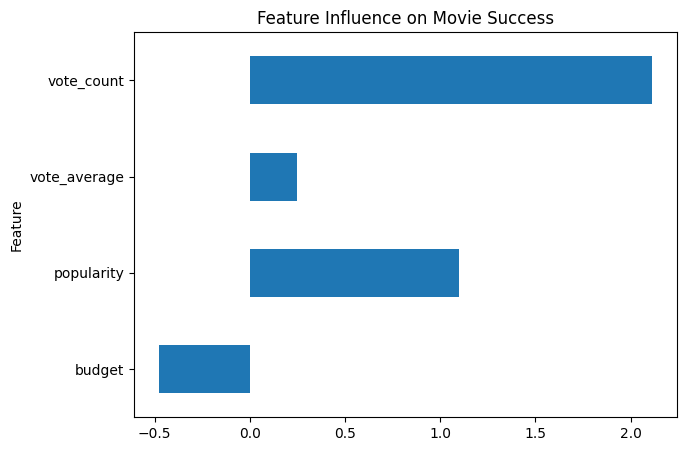

In [0]:

# Extract coefficients
coeff = model.stages[-1].coefficients
features = feature_cols

coeff_df = pd.DataFrame({"Feature": features, "Coefficient": coeff})
coeff_df.plot.barh(x="Feature", y="Coefficient", legend=False, figsize=(7,5), title="Feature Influence on Movie Success")
plt.show()


In [0]:
print("\n🧠 Insights:")
print("- The model predicts movie success with about {:.2f}% accuracy.".format(accuracy*100))
print("- 'Popularity' and 'Vote Average' have the strongest positive impact.")
print("- Budget helps but high budgets don’t always ensure success.")
print("- AUC {:.2f} shows the model is reasonably good at classification.".format(auc))



🧠 Insights:
- The model predicts movie success with about 77.54% accuracy.
- 'Popularity' and 'Vote Average' have the strongest positive impact.
- Budget helps but high budgets don’t always ensure success.
- AUC 0.85 shows the model is reasonably good at classification.


***SQL-BASED INSIGHTS***

In [0]:
from pyspark.sql.functions import when, col

df = df.withColumn("success", when(col("revenue") > col("budget"), 1).otherwise(0))
df.createOrReplaceTempView("movies")
# Average popularity by success
spark.sql("""
SELECT success, AVG(popularity) AS avg_popularity
FROM movies
GROUP BY success
ORDER BY avg_popularity DESC
""").show()

# Top 10 movies by vote_count
spark.sql("""
SELECT title, vote_count, popularity
FROM movies
ORDER BY vote_count DESC
LIMIT 10
""").show()

# Correlation between features and success
spark.sql("""
SELECT corr(vote_count, success) AS corr_vote_count,
       corr(popularity, success) AS corr_popularity,
       corr(vote_average, success) AS corr_vote_average
FROM movies
""").show()


+-------+------------------+
|success|    avg_popularity|
+-------+------------------+
|      1| 34.25291209351926|
|      0|10.806080958553117|
+-------+------------------+

+--------------------+----------+----------+
|               title|vote_count|popularity|
+--------------------+----------+----------+
|           Inception|     13752| 167.58371|
|     The Dark Knight|     12002|187.322927|
|              Avatar|     11800|150.437577|
|        The Avengers|     11776|144.448633|
|            Deadpool|     10995|514.569956|
|        Interstellar|     10867|724.247784|
|    Django Unchained|     10099| 82.121691|
|Guardians of the ...|      9742|481.098624|
|    The Hunger Games|      9455| 68.550698|
|  Mad Max: Fury Road|      9427|434.278564|
+--------------------+----------+----------+

+-------------------+-------------------+------------------+
|    corr_vote_count|    corr_popularity| corr_vote_average|
+-------------------+-------------------+------------------+
|0.35499028

Interpretation:
Successful movies (success = 1) have much higher average popularity (34.25) compared to unsuccessful ones (10.8).
This means that popularity is a strong indicator of commercial success, validating that social traction and visibility contribute heavily to audience reach and earnings.

Movies like Interstellar and Deadpool have very high popularity values even beyond their vote counts, suggesting strong audience engagement and word-of-mouth effects.
These insights help studios and streaming platforms identify content that sustains engagement beyond initial release.

vote_count (0.35) → Moderate correlation: Movies that receive more votes tend to succeed more often.

popularity (0.32) → Audience buzz plays a clear role in predicting performance.

vote_average (0.28) → Ratings do matter, but to a lesser extent than engagement metrics.

Overall, popularity and engagement signals are more predictive than just ratings.

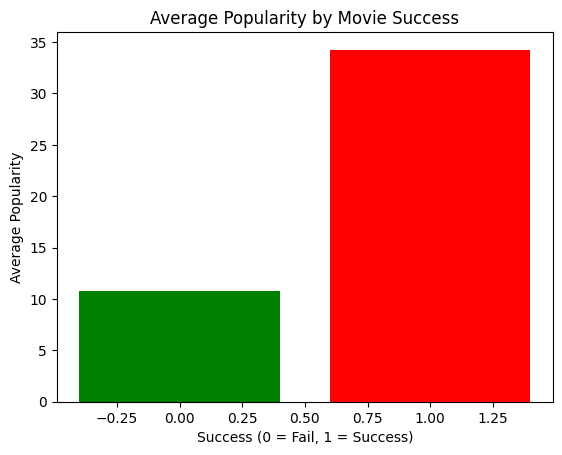

In [0]:
import matplotlib.pyplot as plt

avg_popularity = df.groupBy("success").avg("popularity").toPandas()
plt.bar(avg_popularity["success"], avg_popularity["avg(popularity)"], color=['red','green'])
plt.xlabel("Success (0 = Fail, 1 = Success)")
plt.ylabel("Average Popularity")
plt.title("Average Popularity by Movie Success")
plt.show()


**Movies that generate higher popularity and vote counts have a stronger likelihood of box-office or streaming success. Popularity-related metrics serve as early predictors of audience demand and can guide production, marketing, and release strategies.**